# <center> __COSC 3380 - Machine Learning I (Spring 2021)__ </center>

# <font color=green>*Capstone Project*</font>
### Student Name: Cory Munselle
### Date: 05/10/2021
### Description: Classify different songs based on genre


<font color=red>Before I begin training different models, I want to understand how librosa works and talk a bit about what information we'll be extracting from our music to train our models.</font>

In [1]:
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import preprocessing
import os
from PIL import Image
import pathlib
import csv
import librosa
import librosa.display
import IPython.display as ipd

test_audio = './Music Genres Dataset/genres/blues/blues.00000.wav'

y, sr = librosa.load(test_audio, sr=None)

ipd.Audio(test_audio)

<font color='red'>This is just a test to show how loading works in librosa as well as displaying how IPython has built-in audio display features. It's also verification that the file is properly being loaded.</font>

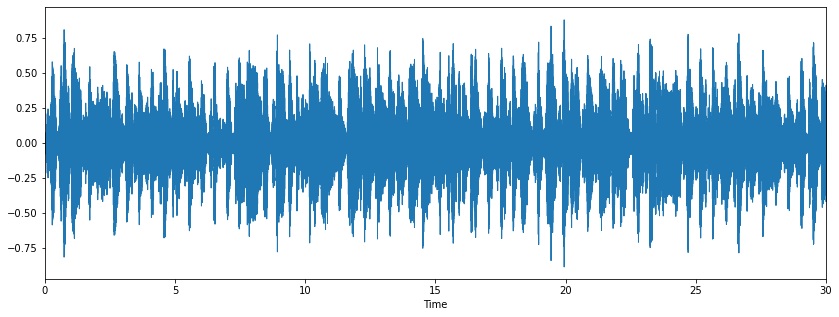

In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

<font color='red'>Graphing seems to work through librosa's built in display functionality. What's interesting is how it's mapped: the left part represents the amplitude envelope, which is the change in amplitude of a sound over time. The envelope is mapped between 0 and 1 inclusive, represented the relative 'strength' of the sound wave.</font>

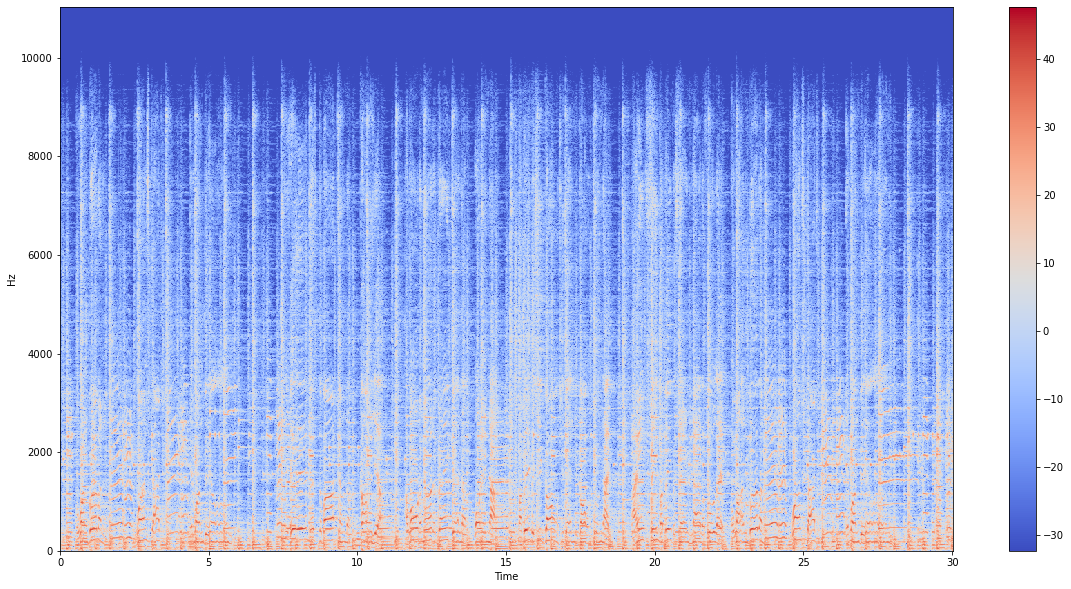

In [4]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 10))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

<font color='red'>This is a spectrogram, which is a colored representation of the different frequencies of any given sound. Spectrograms are displayed as a heatmap, with the more red sections of the spectrogram being more intense. Given the representation of our blues song, we can tell that most of the sound resides on the lower end of the frequency spectrum.</font>

16


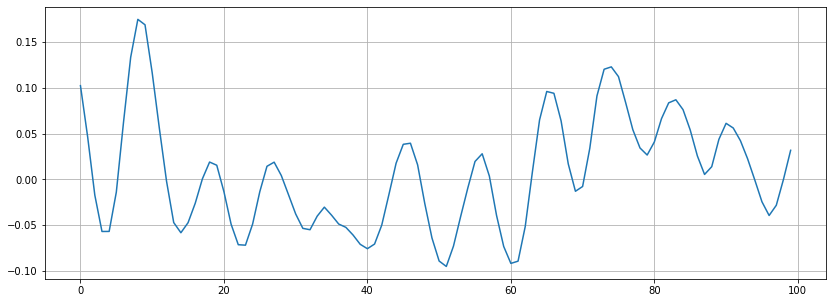

In [5]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(y[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

<font color='red'>This a graph of the zero crossing rate, or the number of times the song goes from a positive amplitude to a negative one. This can be viewed as a 'gap' in the sound, as the sound wave goes from a peak to a trough and the air fills in the gap that the instrument displaced. Songs with many percussive instruments often have many zero crossings, because the sound is generated in bursts from striking, so we can use this to identify music with strong percussive elements. 

As a note, this graph is a zoomed in version of the entire song, so it's not necessarily representative of the entire song. This is just for demonstration purposes.</font>

In [6]:
zero_crossings = librosa.zero_crossings(y, pad=False)
print(sum(zero_crossings))

55031


<font color='red'>As you can see, it crosses the zero line a *lot*. However, we can expect this number to be much higher in songs with heavier percussion, like rock.</font>

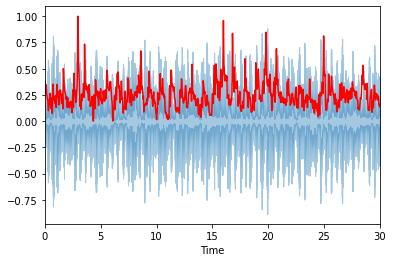

In [7]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(y, axis=0):
    return preprocessing.minmax_scale(y, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

<font color='red'>The Spectral Centroids are a bit complicated to explain, but to put it simply it is the weighted mean of the frequencies of sound. It represents the 'center of mass' for a song, and is very closely correlated with brightness in sound (namely songs that have stronger treble). For a blues song, that doesn't have too many high frequency moments, the center of mass is hard to make out because it remains consistent throughout the song. It would be much more noticable with brighter instruments like clarinets and violins.</font>


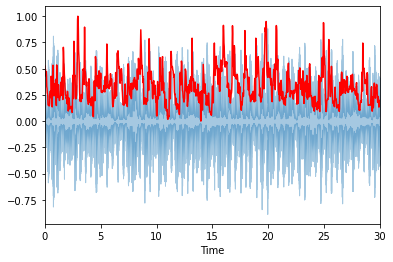

In [8]:
spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

<font color='red'>This is the spectral rolloff of the signal, or the frequency below which a specified percentage of the total spectral energy lies. For example, if the percentage was 85%, the value would return how many frames had that contained less than 85% of the total spectral energy. This is harder to tie to a particular genre, but the idea is songs with more fluctuations will have a very different spectral rolloff value.</font>

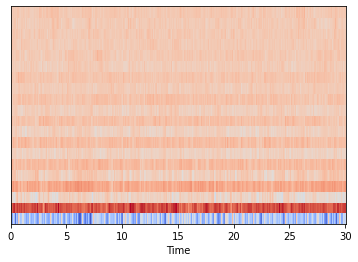

In [9]:
mfccs = librosa.feature.mfcc(y, sr=sr)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

C:\Users\Cory\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Cory\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


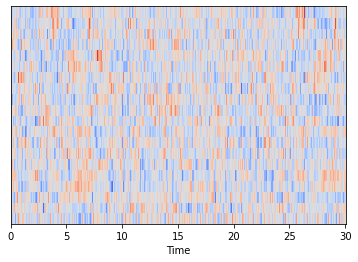

In [10]:
mfccs = preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

<font color='red'>These are called MFCCs, or Mel-frequency cepstrum coefficients. They are a complex transformation of sound to give a representation of the short-term power spectrum of a sound, and are very useful for identifying vocals in audio. They mimic the human voice in a lot of ways. As a note, these graphs look legitimately terrible and don't represent much visually. The important part is the data itself.</font>

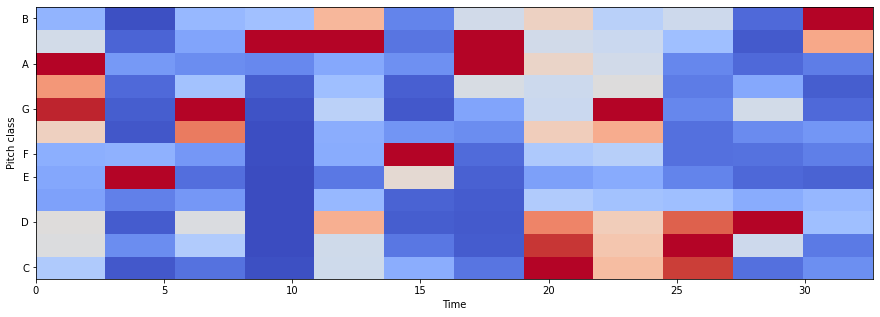

In [11]:
hop_length = 60000
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

<font color='red'>This is a chromagram, a graph that represents the various pitches that any song plays at a given time. The idea is simply to translate the frequency into one of the 12 semitones in an octave and plot it onto a heatmap, with the red colors being the pitch being hit. The closer you get to blue, the less present the note is. It's a great way to translate a spectrum into something that exists in a more traditional musical environment. </font>

In [ ]:
#Credit goes to Parul Pandey for the quick and dirty loading code to get the csv file made.
#https://gist.github.com/parulnith/7f8c174e6ac099e86f0495d3d9a4c01e#file-music_genre_classification-ipynb

header = 'tempo chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('music_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.libeatr(f'./Music Genres Dataset/genres/{g}'):
        songname = f'./Music Genres Dataset/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        tempo = librosa.beat.tempo(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rmse(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(tempo)} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('music_data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

<font color='red'>This code above takes all of the files, processes them, and puts it in a csv file that I can load in later so I don't have to constantly reload the files. This should save space and processing time overall.</font>

In [14]:
musicData = pnd.read_csv('music_data.csv', header=0)

musicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [15]:
#We're going to encode the labels for future use. It may be useful, but I'll put it in a numpy array in case it isn't.
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(musicData['label'])

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [16]:
#Now to separate the rest and put it in a dataframe so we can make a train/test split on the data
#I'm not going to be standard scaling any of the data yet because I want to see how well things perform without it

X = musicData.drop(columns=['label'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [17]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = 0.2, random_state=42)

len(features_train)

len(labels_train)

800

<font color='blue'>Later edit: I ended up calling the same models over and over again so I figured I should just make a function out of them so I can call them easier. They will be placed here.</font>

In [24]:
import scikitplot as skplt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error

def rfModelRun(features_train, labels_train, features_test, labels_test, matrix=False):
    RFModel = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=1)
    RFModel.fit(features_train, labels_train)

    RFScore = RFModel.score(features_train, labels_train)
    print("Base training score: %.5f" % RFScore)
    RFScore = RFModel.score(features_test, labels_test)
    print("Base testing score: %.5f" % RFScore)

    predictions = RFModel.predict(features_test)

    print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
        
    return RFModel
    
def xtModelRun(features_train, labels_train, features_test, labels_test, matrix=False):
    ETClass = ExtraTreesClassifier(n_estimators=1000, random_state=1)
    ETClass.fit(features_train, labels_train)

    ETScore = ETClass.score(features_train, labels_train)
    print("Base training score: %.5f" % ETScore)
    ETScore = ETClass.score(features_test, labels_test)
    print("Base testing score: %.5f" % ETScore)

    predictions = ETClass.predict(features_test)

    print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
    
    return ETClass

def knModelRun(features_train, labels_train, features_test, labels_test, matrix=False):
    KNModel = KNeighborsClassifier()
    KNModel.fit(features_train, labels_train)

    KNScore = KNModel.score(features_train, labels_train)
    print("Base training score: %.5f" % KNScore)
    KNScore = KNModel.score(features_test, labels_test)
    print("Base testing score: %.5f" % KNScore)

    predictions = KNModel.predict(features_test)

    print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
    
    return KNModel

def svcModelRun(features_train, labels_train, features_test, labels_test, matrix=False):
    SVCModel = SVC(kernel='linear', probability=True)
    SVCModel.fit(features_train, labels_train)

    SVCscore = SVCModel.score(features_train, labels_train)
    print("Base training score: %.5f" % SVCscore)
    SVCscore = SVCModel.score(features_test, labels_test)
    print("Base testing score: %.5f" % SVCscore)

    predictions = SVCModel.predict(features_test)

    print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
    
    return SVCModel

def voteModelRun(estimators, vote, features_train, labels_train, features_test, labels_test, matrix=False):
    VoteModel = VotingClassifier(
        estimators=estimators,
        voting=vote)
    VoteModel.fit(features_train, labels_train)
    VoteScore = VoteModel.score(features_train, labels_train)
    print("Base training score:", VoteScore)
    VoteScore = VoteModel.score(features_test, labels_test)
    print("Base validation score:", VoteScore)

    Votepredictions = VoteModel.predict(features_test)

    print('Accuracy:', accuracy_score(labels_test, Votepredictions))

    if matrix == False:
        print(classification_report(labels_test, Votepredictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(Votepredictions)
        model_metrics(y_test,y_pred_nb)
    
    return VoteModel

def bagModelRun(classifier, features_train, labels_train, features_test, labels_test, matrix=False):
    BagModel = BaggingClassifier(
        classifier, n_estimators=500,
        max_samples=100, bootstrap=False, n_jobs=-1)
    BagModel.fit(features_train, labels_train)
    BagScore = BagModel.score(features_train, labels_train)
    print("Base training score:", BagScore)
    BagScore = BagModel.score(features_test, labels_test)
    print("Base validation score:", BagScore)

    predictions = BagModel.predict(features_test)

    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
    
    return BagModel

def boostModelRun(classifier, features_train, labels_train, features_test, labels_test, matrix=False):
    AdaBoost = AdaBoostClassifier(
        classifier, n_estimators=10,
        algorithm="SAMME.R", learning_rate=0.35)
    AdaBoost.fit(features_train, labels_train)

    AdaScore = AdaBoost.score(features_train, labels_train)
    print("Base training score:", AdaScore)

    predictions = AdaBoost.predict(features_test)

    print('Accuracy:', accuracy_score(labels_test, predictions))
    
    if matrix == False:
        print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))
    else:
        y_test = label_encoder.inverse_transform(labels_test)
        y_pred_nb = label_encoder.inverse_transform(predictions)
        model_metrics(y_test,y_pred_nb)
    
    return AdaBoost

def model_metrics(y_test,y_pred):
    print("Decoded genres after applying inverse of label encoder : " + str(np.unique(y_pred)))
    skplt.metrics.plot_confusion_matrix(y_test,y_pred,text_fontsize="small",cmap='Greens',figsize=(10,8))
    plt.show()
    print("The classification report for the model : \n\n"+ classification_report(y_test, y_pred))

<font color='red'>Now that a training and testing dataset have been created, we're going to try throwing it against a few models to see how well it performs. Ensembling is going to be done in the future, but I want to isolate the best performing algorithms first.</font>

In [40]:
RFModel = rfModelRun(features_train, labels_train, features_test, labels_test, False)

Base training score: 0.79750
Base testing score: 0.50500
Mean Absolute Error (MAE): 1.955
Accuracy: 0.505
              precision    recall  f1-score   support

       blues       0.33      0.30      0.32        20
   classical       0.87      1.00      0.93        13
     country       0.50      0.15      0.23        27
       disco       0.50      0.38      0.43        21
      hiphop       0.33      0.60      0.43        15
        jazz       0.59      0.77      0.67        22
       metal       0.56      0.88      0.69        25
         pop       0.43      0.46      0.44        13
      reggae       0.58      0.48      0.52        23
        rock       0.33      0.24      0.28        21

    accuracy                           0.51       200
   macro avg       0.50      0.53      0.49       200
weighted avg       0.50      0.51      0.48       200



<font color='red'>A respectable result! For no scaling 48.5% accuracy is better than I would have expected, although we can definitely alter a few things in the future to refine this. That's for later, though: lets continue with different algorithms.</font>

In [41]:
ETClass = xtModelRun(features_train, labels_train, features_test, labels_test, False)

Base training score: 0.99875
Base testing score: 0.66000
Mean Absolute Error (MAE): 1.465
Accuracy: 0.66
              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        20
   classical       0.81      1.00      0.90        13
     country       0.67      0.74      0.70        27
       disco       0.71      0.57      0.63        21
      hiphop       0.41      0.47      0.44        15
        jazz       0.75      0.82      0.78        22
       metal       0.74      0.92      0.82        25
         pop       0.50      0.62      0.55        13
      reggae       0.59      0.43      0.50        23
        rock       0.56      0.43      0.49        21

    accuracy                           0.66       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



<font color='red'>This result was quite a bit better than Random Forests, which is a good sign. It's indicating that Extra Trees might be a better choice over Random Forests for our future ensemble, but I'm going to run a few more algorithms before I say that.</font>

In [42]:
KNModel = knModelRun(features_train, labels_train, features_test, labels_test, False)

Base training score: 0.55375
Base testing score: 0.31000
Mean Absolute Error (MAE): 2.415
Accuracy: 0.31
              precision    recall  f1-score   support

       blues       0.31      0.40      0.35        20
   classical       0.79      0.85      0.81        13
     country       0.17      0.15      0.16        27
       disco       0.19      0.24      0.21        21
      hiphop       0.11      0.20      0.14        15
        jazz       0.27      0.18      0.22        22
       metal       0.57      0.64      0.60        25
         pop       0.36      0.38      0.37        13
      reggae       0.29      0.17      0.22        23
        rock       0.18      0.10      0.12        21

    accuracy                           0.31       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.31      0.31      0.30       200



<font color='red'>Hmm, looks like the worst result so far. I can't say I'm surprised, if only because KNN is at a disadvantage compared to the previous two (they're both technically ensemble methods). However, I'm not going to count it out yet!</font>

In [43]:
#SVCModel = svcModelRun(features_train, labels_train, features_test, labels_test, False)

<font color='red'>This is a solid result too. I'm noticing a pattern start to occur, where most of the algorithms seem to excel at genres like classical but only Extra Trees has really gotten anywhere close to accurate with rock. 
    
Given the cheat sheet, I think these algorithms we've tried are the most appropriate for our application. In this instance, I think it would be best to try standard scaling some of the data to hopefully get better results.</font>

In [19]:
standard_scaler = preprocessing.StandardScaler()

X_scaled = standard_scaler.fit_transform(X)

scaledMusicData = pnd.DataFrame(X_scaled, columns=X.columns)

scaledMusicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [46]:
#Make new splits based on new scaled data
features_train, features_test, labels_train, labels_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

Base training score: 0.79750
Base testing score: 0.50500
Mean Absolute Error (MAE): 1.955
Accuracy: 0.505
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


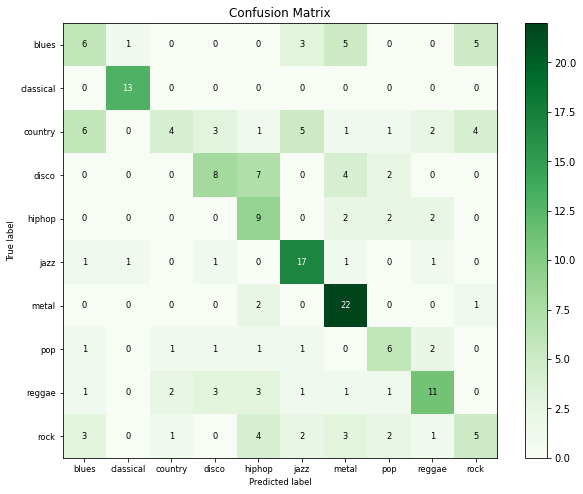

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.33      0.30      0.32        20
   classical       0.87      1.00      0.93        13
     country       0.50      0.15      0.23        27
       disco       0.50      0.38      0.43        21
      hiphop       0.33      0.60      0.43        15
        jazz       0.59      0.77      0.67        22
       metal       0.56      0.88      0.69        25
         pop       0.43      0.46      0.44        13
      reggae       0.58      0.48      0.52        23
        rock       0.33      0.24      0.28        21

    accuracy                           0.51       200
   macro avg       0.50      0.53      0.49       200
weighted avg       0.50      0.51      0.48       200



In [47]:
RFModel = rfModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Base testing score: 0.66000
Mean Absolute Error (MAE): 1.465
Accuracy: 0.66
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


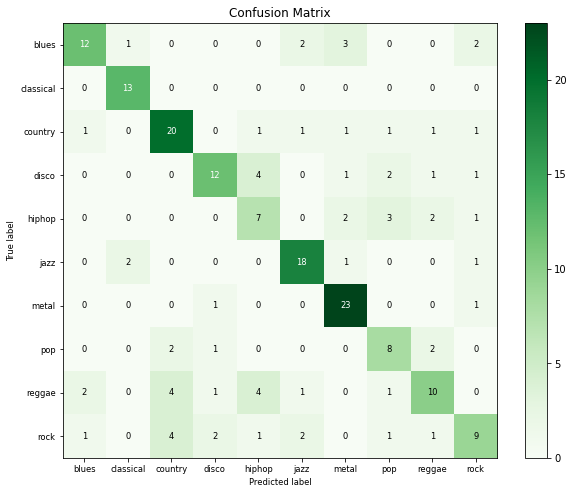

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        20
   classical       0.81      1.00      0.90        13
     country       0.67      0.74      0.70        27
       disco       0.71      0.57      0.63        21
      hiphop       0.41      0.47      0.44        15
        jazz       0.75      0.82      0.78        22
       metal       0.74      0.92      0.82        25
         pop       0.50      0.62      0.55        13
      reggae       0.59      0.43      0.50        23
        rock       0.56      0.43      0.49        21

    accuracy                           0.66       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



In [48]:
ETClass = xtModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.73875
Base testing score: 0.59000
Mean Absolute Error (MAE): 1.66
Accuracy: 0.59
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


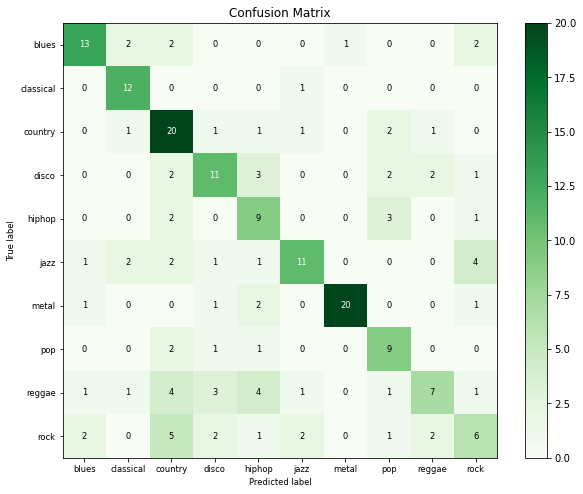

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.72      0.65      0.68        20
   classical       0.67      0.92      0.77        13
     country       0.51      0.74      0.61        27
       disco       0.55      0.52      0.54        21
      hiphop       0.41      0.60      0.49        15
        jazz       0.69      0.50      0.58        22
       metal       0.95      0.80      0.87        25
         pop       0.50      0.69      0.58        13
      reggae       0.58      0.30      0.40        23
        rock       0.38      0.29      0.32        21

    accuracy                           0.59       200
   macro avg       0.60      0.60      0.58       200
weighted avg       0.61      0.59      0.58       200



In [49]:
KNModel = knModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.80250
Base testing score: 0.59000
Mean Absolute Error (MAE): 1.57
Accuracy: 0.59
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


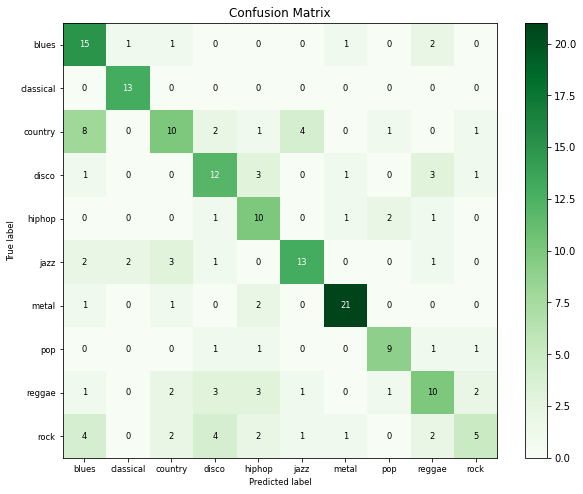

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.47      0.75      0.58        20
   classical       0.81      1.00      0.90        13
     country       0.53      0.37      0.43        27
       disco       0.50      0.57      0.53        21
      hiphop       0.45      0.67      0.54        15
        jazz       0.68      0.59      0.63        22
       metal       0.84      0.84      0.84        25
         pop       0.69      0.69      0.69        13
      reggae       0.50      0.43      0.47        23
        rock       0.50      0.24      0.32        21

    accuracy                           0.59       200
   macro avg       0.60      0.62      0.59       200
weighted avg       0.59      0.59      0.58       200



In [50]:
SVCModel = svcModelRun(features_train, labels_train, features_test, labels_test, True)

<font color='red'>Wow, the KNN model improved a significant amount after standardizing the data, and it looks like none of the other algorithms had any worse performance as a result! Out of the ones we tried, it looks like our best options are Extra Trees, SVC, and KNN for our ensemble. Let's try it!</font>

Base training score: 0.9025
Base validation score: 0.66
Accuracy: 0.66
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


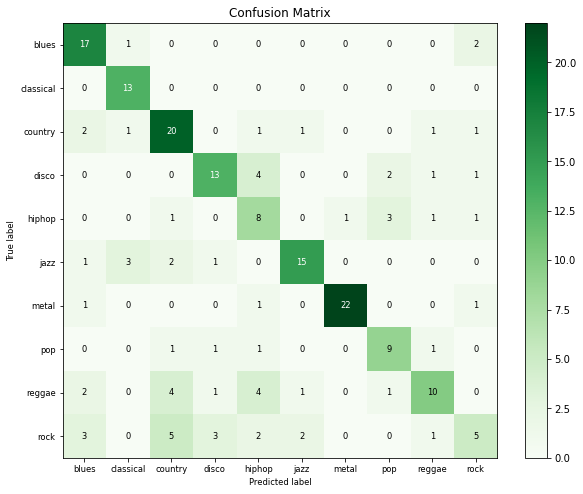

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.65      0.85      0.74        20
   classical       0.72      1.00      0.84        13
     country       0.61      0.74      0.67        27
       disco       0.68      0.62      0.65        21
      hiphop       0.38      0.53      0.44        15
        jazz       0.79      0.68      0.73        22
       metal       0.96      0.88      0.92        25
         pop       0.60      0.69      0.64        13
      reggae       0.67      0.43      0.53        23
        rock       0.45      0.24      0.31        21

    accuracy                           0.66       200
   macro avg       0.65      0.67      0.65       200
weighted avg       0.66      0.66      0.65       200



In [51]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'hard', features_train, labels_train, features_test, labels_test, True)

Base training score: 0.9975
Base validation score: 0.685
Accuracy: 0.685
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


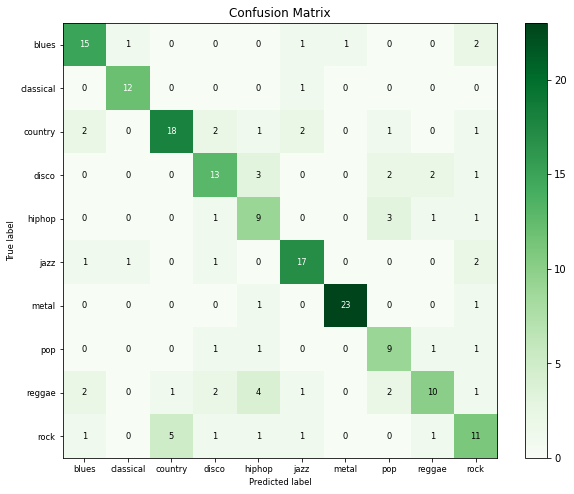

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.71      0.75      0.73        20
   classical       0.86      0.92      0.89        13
     country       0.75      0.67      0.71        27
       disco       0.62      0.62      0.62        21
      hiphop       0.45      0.60      0.51        15
        jazz       0.74      0.77      0.76        22
       metal       0.96      0.92      0.94        25
         pop       0.53      0.69      0.60        13
      reggae       0.67      0.43      0.53        23
        rock       0.52      0.52      0.52        21

    accuracy                           0.69       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



In [52]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'soft', features_train, labels_train, features_test, labels_test, True)

<font color='red'>Hmm, doesn't look like our ensemble method really improved anything that much. 69% isn't terrible, but I'm curious to see if we can squeeze out more accuracy. Since the score isn't much higher than Extra Trees, how about we try bagging with Extra Trees to see if we can get a better result?</font>

Base training score: 0.9025
Base validation score: 0.535
Accuracy: 0.535
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


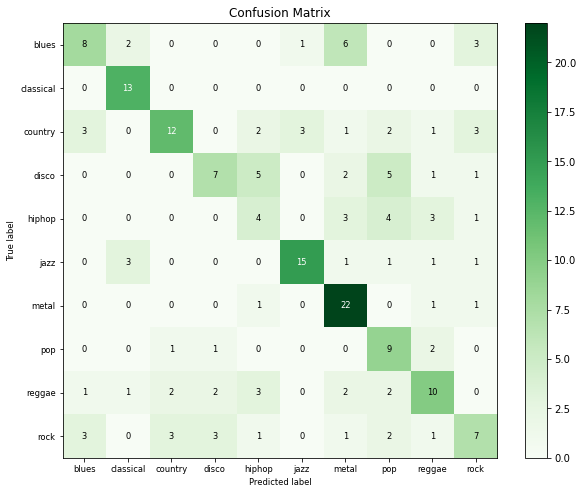

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.53      0.40      0.46        20
   classical       0.68      1.00      0.81        13
     country       0.67      0.44      0.53        27
       disco       0.54      0.33      0.41        21
      hiphop       0.25      0.27      0.26        15
        jazz       0.79      0.68      0.73        22
       metal       0.58      0.88      0.70        25
         pop       0.36      0.69      0.47        13
      reggae       0.50      0.43      0.47        23
        rock       0.41      0.33      0.37        21

    accuracy                           0.54       200
   macro avg       0.53      0.55      0.52       200
weighted avg       0.55      0.54      0.52       200



In [53]:
classifier = ExtraTreesClassifier()
BagModel = bagModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>Hmm, that's a worse score than the initial Extra Trees we ran. I tested both bagging and pasting, with pasting getting a slightly better score, but neither result competes with either the initial Extra Trees classifier or the voting ensemble methods. Could the issue be with Extra Trees, since it's already an ensemble? Let's test with KNN...</font>

Base training score: 0.60125
Base validation score: 0.5
Accuracy: 0.5
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


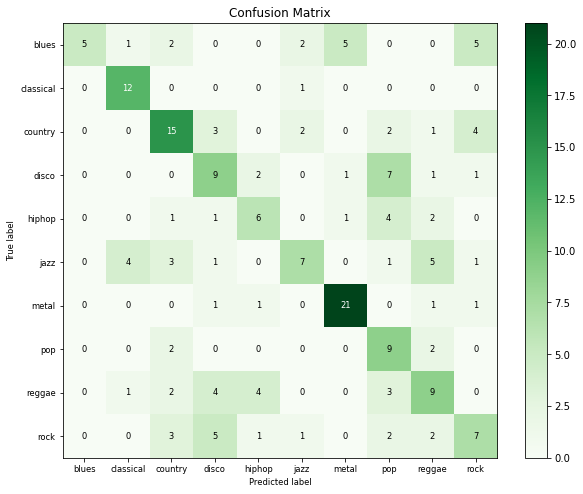

The classification report for the model : 

              precision    recall  f1-score   support

       blues       1.00      0.25      0.40        20
   classical       0.67      0.92      0.77        13
     country       0.54      0.56      0.55        27
       disco       0.38      0.43      0.40        21
      hiphop       0.43      0.40      0.41        15
        jazz       0.54      0.32      0.40        22
       metal       0.75      0.84      0.79        25
         pop       0.32      0.69      0.44        13
      reggae       0.39      0.39      0.39        23
        rock       0.37      0.33      0.35        21

    accuracy                           0.50       200
   macro avg       0.54      0.51      0.49       200
weighted avg       0.54      0.50      0.49       200



In [54]:
classifier = KNeighborsClassifier()
BagModel = bagModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>Ouch, this is an even worse result. I think my only real option now would be to try some boosting to see if that yields better results.</font>

Base training score: 0.99875
Accuracy: 0.67
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


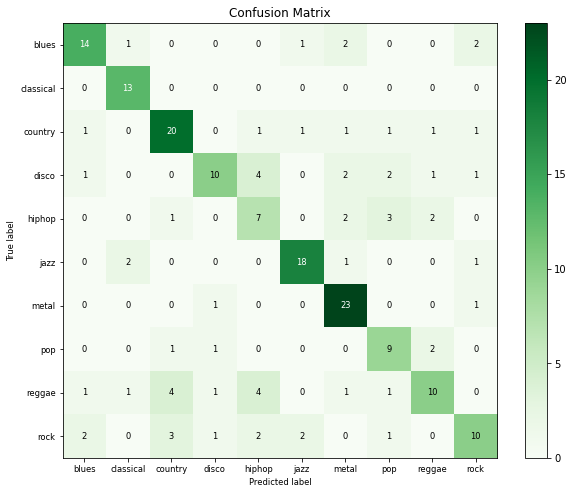

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.74      0.70      0.72        20
   classical       0.76      1.00      0.87        13
     country       0.69      0.74      0.71        27
       disco       0.71      0.48      0.57        21
      hiphop       0.39      0.47      0.42        15
        jazz       0.82      0.82      0.82        22
       metal       0.72      0.92      0.81        25
         pop       0.53      0.69      0.60        13
      reggae       0.62      0.43      0.51        23
        rock       0.62      0.48      0.54        21

    accuracy                           0.67       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200



In [55]:
classifier = ExtraTreesClassifier()
AdaBoost = boostModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>Okay, 68% is quite a good result, but we might be able to coax out even more performance. Let's take a look at a correlation heatmap to see what features have the strongest correlation.</font>

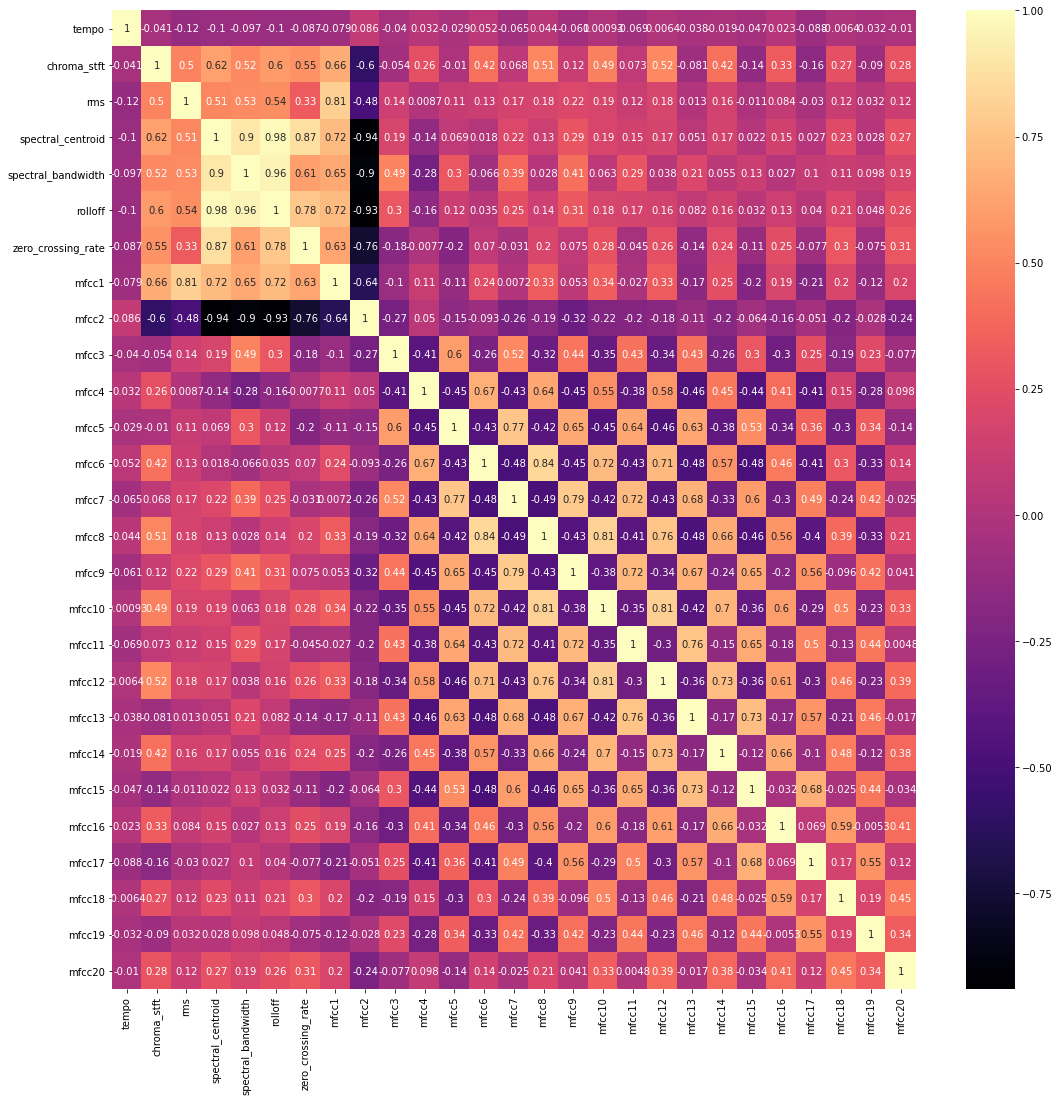

In [35]:
plt.figure(figsize=(18,18))
p=sns.heatmap(scaledMusicData.corr(), annot=True,cmap ='magma') 

<font color='red'>So it looks like tempo is the only feature that has very poor correlation across all other features. That's going to be removed, but we'll keep an eye on mfcc20 and mfcc19 as well since they don't have any very strong correlations.</font>

In [56]:
finalMusicData = scaledMusicData.drop(columns=['tempo'], axis=1)

finalMusicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         1000 non-null   float64
 1   rms                 1000 non-null   float64
 2   spectral_centroid   1000 non-null   float64
 3   spectral_bandwidth  1000 non-null   float64
 4   rolloff             1000 non-null   float64
 5   zero_crossing_rate  1000 non-null   float64
 6   mfcc1               1000 non-null   float64
 7   mfcc2               1000 non-null   float64
 8   mfcc3               1000 non-null   float64
 9   mfcc4               1000 non-null   float64
 10  mfcc5               1000 non-null   float64
 11  mfcc6               1000 non-null   float64
 12  mfcc7               1000 non-null   float64
 13  mfcc8               1000 non-null   float64
 14  mfcc9               1000 non-null   float64
 15  mfcc10              1000 non-null   float64
 16  mfcc11 

<font color='red'>We're also going to stratify the train test split to make sure that there's an even number of features across categories:</font>

In [57]:
features_train, features_test, labels_train, labels_test = train_test_split(finalMusicData, y, test_size = 0.2, stratify=y, random_state=42)

Base training score: 0.75750
Base testing score: 0.54500
Mean Absolute Error (MAE): 1.74
Accuracy: 0.545
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


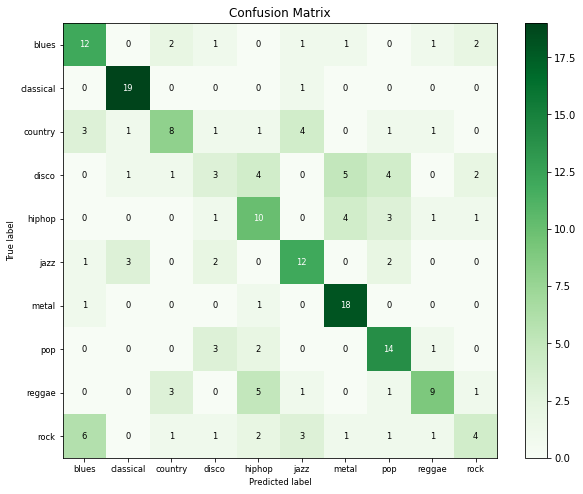

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.52      0.60      0.56        20
   classical       0.79      0.95      0.86        20
     country       0.53      0.40      0.46        20
       disco       0.25      0.15      0.19        20
      hiphop       0.40      0.50      0.44        20
        jazz       0.55      0.60      0.57        20
       metal       0.62      0.90      0.73        20
         pop       0.54      0.70      0.61        20
      reggae       0.64      0.45      0.53        20
        rock       0.40      0.20      0.27        20

    accuracy                           0.55       200
   macro avg       0.52      0.55      0.52       200
weighted avg       0.52      0.55      0.52       200



In [58]:
RFModel = rfModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Base testing score: 0.69000
Mean Absolute Error (MAE): 1.15
Accuracy: 0.69
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


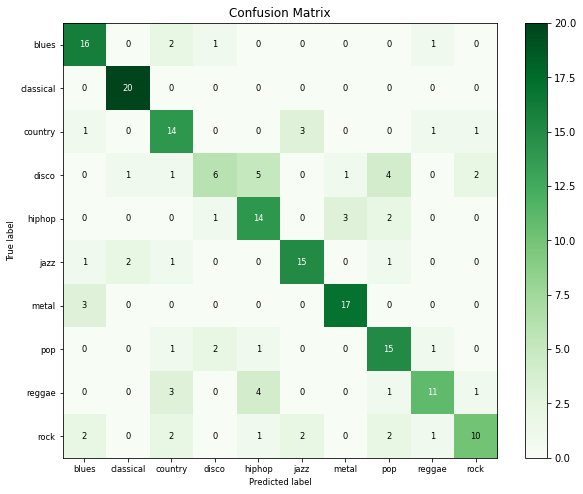

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.70      0.80      0.74        20
   classical       0.87      1.00      0.93        20
     country       0.58      0.70      0.64        20
       disco       0.60      0.30      0.40        20
      hiphop       0.56      0.70      0.62        20
        jazz       0.75      0.75      0.75        20
       metal       0.81      0.85      0.83        20
         pop       0.60      0.75      0.67        20
      reggae       0.73      0.55      0.63        20
        rock       0.71      0.50      0.59        20

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



In [59]:
ETClass = xtModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.77875
Base testing score: 0.59000
Mean Absolute Error (MAE): 1.485
Accuracy: 0.59
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


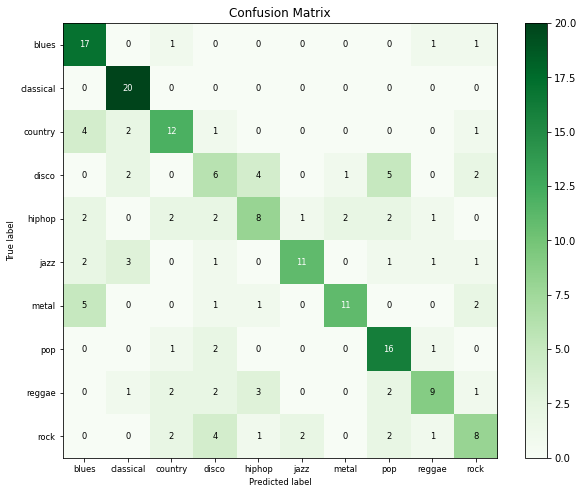

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.57      0.85      0.68        20
   classical       0.71      1.00      0.83        20
     country       0.60      0.60      0.60        20
       disco       0.32      0.30      0.31        20
      hiphop       0.47      0.40      0.43        20
        jazz       0.79      0.55      0.65        20
       metal       0.79      0.55      0.65        20
         pop       0.57      0.80      0.67        20
      reggae       0.64      0.45      0.53        20
        rock       0.50      0.40      0.44        20

    accuracy                           0.59       200
   macro avg       0.60      0.59      0.58       200
weighted avg       0.60      0.59      0.58       200



In [60]:
KNModel = knModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.78625
Base testing score: 0.64500
Mean Absolute Error (MAE): 1.52
Accuracy: 0.645
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


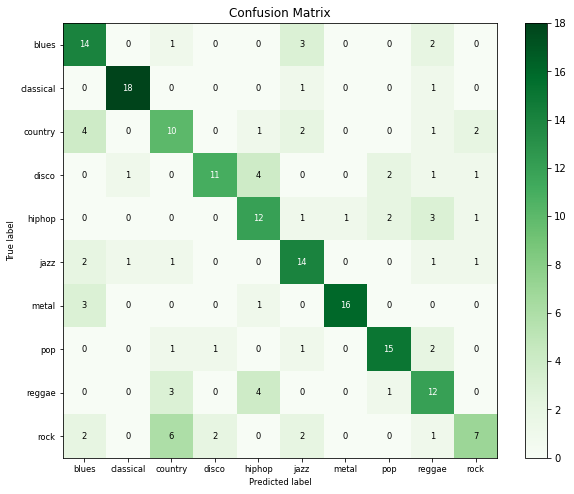

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.56      0.70      0.62        20
   classical       0.90      0.90      0.90        20
     country       0.45      0.50      0.48        20
       disco       0.79      0.55      0.65        20
      hiphop       0.55      0.60      0.57        20
        jazz       0.58      0.70      0.64        20
       metal       0.94      0.80      0.86        20
         pop       0.75      0.75      0.75        20
      reggae       0.50      0.60      0.55        20
        rock       0.58      0.35      0.44        20

    accuracy                           0.65       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.66      0.65      0.65       200



In [61]:
SVCModel = svcModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.9025
Base validation score: 0.67
Accuracy: 0.67
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


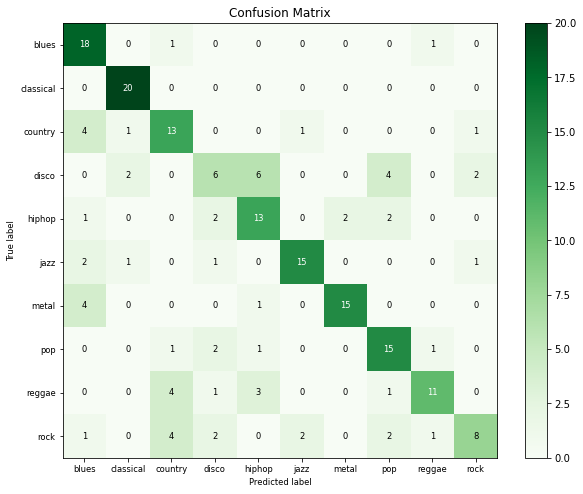

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.60      0.90      0.72        20
   classical       0.83      1.00      0.91        20
     country       0.57      0.65      0.60        20
       disco       0.43      0.30      0.35        20
      hiphop       0.54      0.65      0.59        20
        jazz       0.83      0.75      0.79        20
       metal       0.88      0.75      0.81        20
         pop       0.62      0.75      0.68        20
      reggae       0.79      0.55      0.65        20
        rock       0.67      0.40      0.50        20

    accuracy                           0.67       200
   macro avg       0.68      0.67      0.66       200
weighted avg       0.68      0.67      0.66       200



In [62]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'hard', features_train, labels_train, features_test, labels_test, True)

Base training score: 0.995
Base validation score: 0.68
Accuracy: 0.68
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


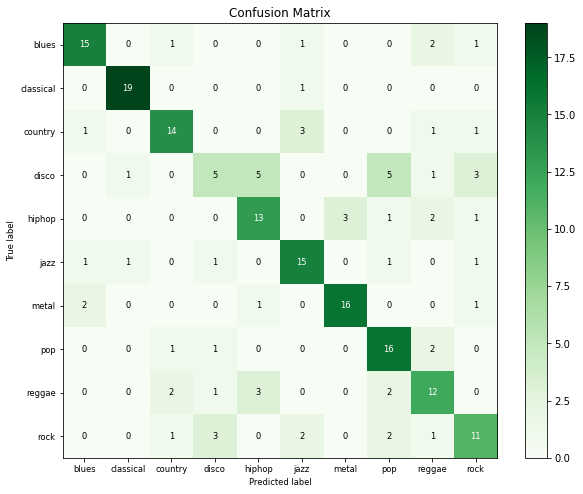

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.79      0.75      0.77        20
   classical       0.90      0.95      0.93        20
     country       0.74      0.70      0.72        20
       disco       0.45      0.25      0.32        20
      hiphop       0.59      0.65      0.62        20
        jazz       0.68      0.75      0.71        20
       metal       0.84      0.80      0.82        20
         pop       0.59      0.80      0.68        20
      reggae       0.57      0.60      0.59        20
        rock       0.58      0.55      0.56        20

    accuracy                           0.68       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.67      0.68      0.67       200



In [63]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'soft', features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Accuracy: 0.71
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


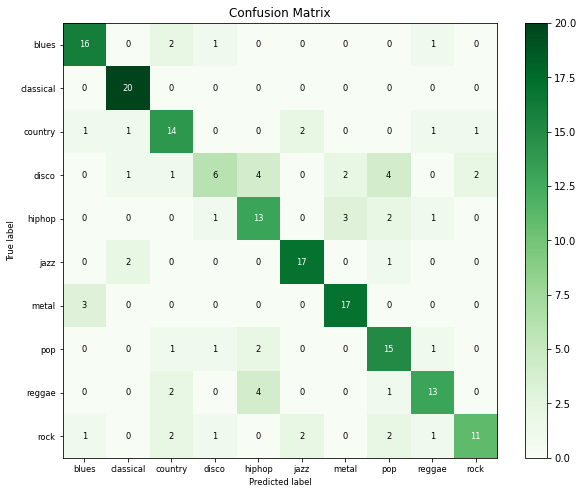

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.83      1.00      0.91        20
     country       0.64      0.70      0.67        20
       disco       0.60      0.30      0.40        20
      hiphop       0.57      0.65      0.60        20
        jazz       0.81      0.85      0.83        20
       metal       0.77      0.85      0.81        20
         pop       0.60      0.75      0.67        20
      reggae       0.72      0.65      0.68        20
        rock       0.79      0.55      0.65        20

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.71      0.71      0.70       200



In [64]:
classifier = ExtraTreesClassifier()
AdaBoost = boostModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>Removing tempo didn't really improve our scores, so I'll try removing mfcc20 and mfcc19. If this doesn't improve significantly, I don't think there's much else I can do besides finding more features to insert, which librosa lacks.</font>

In [65]:
finalMusicData = scaledMusicData.drop(columns=['tempo', 'mfcc20', 'mfcc19'], axis=1)
finalMusicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         1000 non-null   float64
 1   rms                 1000 non-null   float64
 2   spectral_centroid   1000 non-null   float64
 3   spectral_bandwidth  1000 non-null   float64
 4   rolloff             1000 non-null   float64
 5   zero_crossing_rate  1000 non-null   float64
 6   mfcc1               1000 non-null   float64
 7   mfcc2               1000 non-null   float64
 8   mfcc3               1000 non-null   float64
 9   mfcc4               1000 non-null   float64
 10  mfcc5               1000 non-null   float64
 11  mfcc6               1000 non-null   float64
 12  mfcc7               1000 non-null   float64
 13  mfcc8               1000 non-null   float64
 14  mfcc9               1000 non-null   float64
 15  mfcc10              1000 non-null   float64
 16  mfcc11 

In [66]:
features_train, features_test, labels_train, labels_test = train_test_split(finalMusicData, y, test_size = 0.2, stratify=y, random_state=42)

Base training score: 0.75625
Base testing score: 0.54000
Mean Absolute Error (MAE): 1.695
Accuracy: 0.54
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


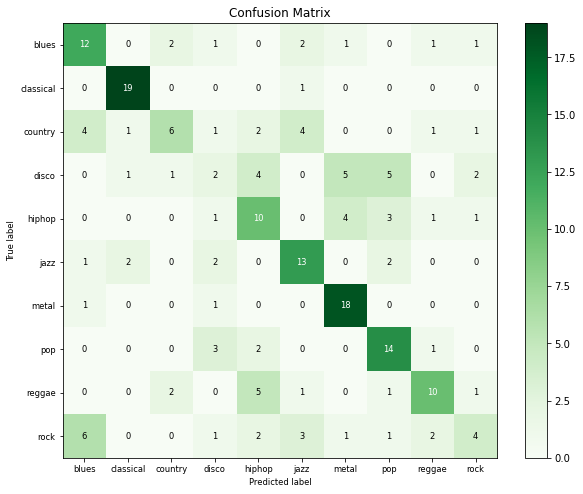

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.50      0.60      0.55        20
   classical       0.83      0.95      0.88        20
     country       0.55      0.30      0.39        20
       disco       0.17      0.10      0.12        20
      hiphop       0.40      0.50      0.44        20
        jazz       0.54      0.65      0.59        20
       metal       0.62      0.90      0.73        20
         pop       0.54      0.70      0.61        20
      reggae       0.62      0.50      0.56        20
        rock       0.40      0.20      0.27        20

    accuracy                           0.54       200
   macro avg       0.52      0.54      0.51       200
weighted avg       0.52      0.54      0.51       200



In [67]:
RFModel = rfModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Base testing score: 0.69500
Mean Absolute Error (MAE): 1.125
Accuracy: 0.695
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


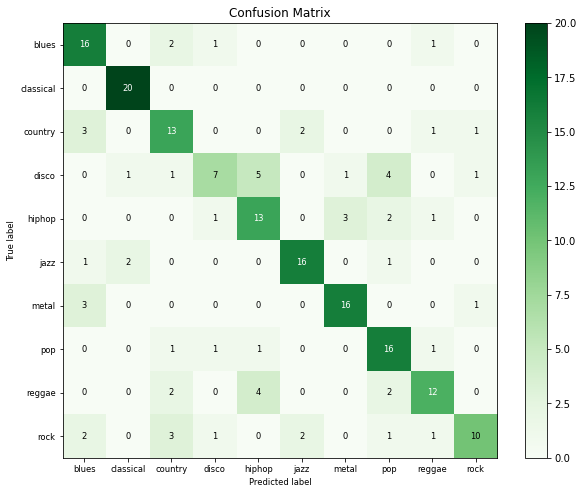

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.64      0.80      0.71        20
   classical       0.87      1.00      0.93        20
     country       0.59      0.65      0.62        20
       disco       0.64      0.35      0.45        20
      hiphop       0.57      0.65      0.60        20
        jazz       0.80      0.80      0.80        20
       metal       0.80      0.80      0.80        20
         pop       0.62      0.80      0.70        20
      reggae       0.71      0.60      0.65        20
        rock       0.77      0.50      0.61        20

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200



In [68]:
ETClass = xtModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.76750
Base testing score: 0.62500
Mean Absolute Error (MAE): 1.36
Accuracy: 0.625
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


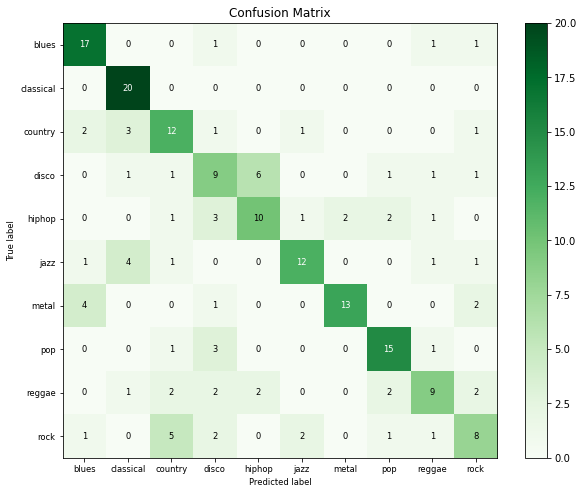

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.68      0.85      0.76        20
   classical       0.69      1.00      0.82        20
     country       0.52      0.60      0.56        20
       disco       0.41      0.45      0.43        20
      hiphop       0.56      0.50      0.53        20
        jazz       0.75      0.60      0.67        20
       metal       0.87      0.65      0.74        20
         pop       0.71      0.75      0.73        20
      reggae       0.60      0.45      0.51        20
        rock       0.50      0.40      0.44        20

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.62       200



In [69]:
KNModel = knModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.77750
Base testing score: 0.64000
Mean Absolute Error (MAE): 1.425
Accuracy: 0.64
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


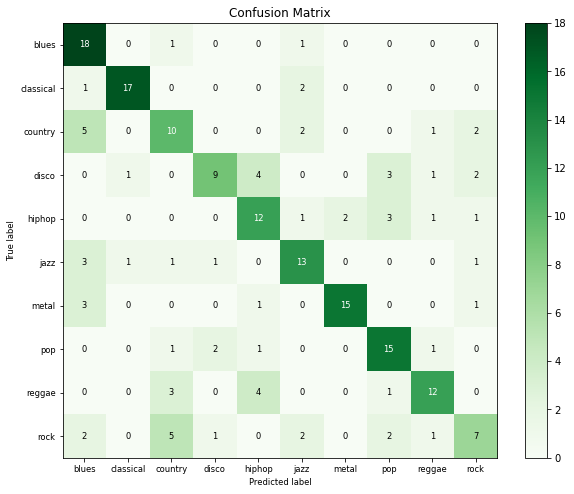

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.56      0.90      0.69        20
   classical       0.89      0.85      0.87        20
     country       0.48      0.50      0.49        20
       disco       0.69      0.45      0.55        20
      hiphop       0.55      0.60      0.57        20
        jazz       0.62      0.65      0.63        20
       metal       0.88      0.75      0.81        20
         pop       0.62      0.75      0.68        20
      reggae       0.71      0.60      0.65        20
        rock       0.50      0.35      0.41        20

    accuracy                           0.64       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.65      0.64      0.64       200



In [70]:
SVCModel = svcModelRun(features_train, labels_train, features_test, labels_test, True)

Base training score: 0.90125
Base validation score: 0.695
Accuracy: 0.695
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


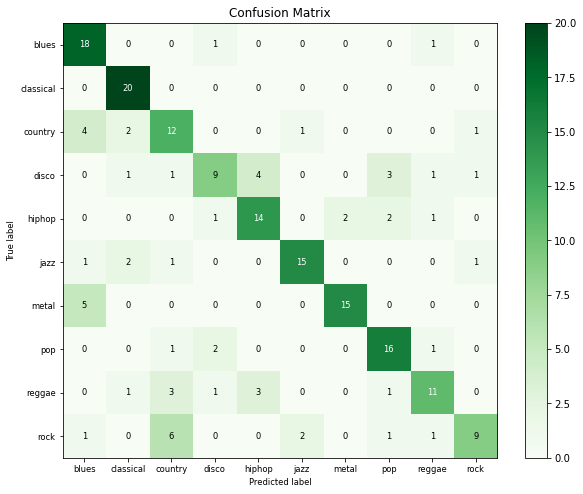

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.62      0.90      0.73        20
   classical       0.77      1.00      0.87        20
     country       0.50      0.60      0.55        20
       disco       0.64      0.45      0.53        20
      hiphop       0.67      0.70      0.68        20
        jazz       0.83      0.75      0.79        20
       metal       0.88      0.75      0.81        20
         pop       0.70      0.80      0.74        20
      reggae       0.69      0.55      0.61        20
        rock       0.75      0.45      0.56        20

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



In [71]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'hard', features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Base validation score: 0.7
Accuracy: 0.7
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


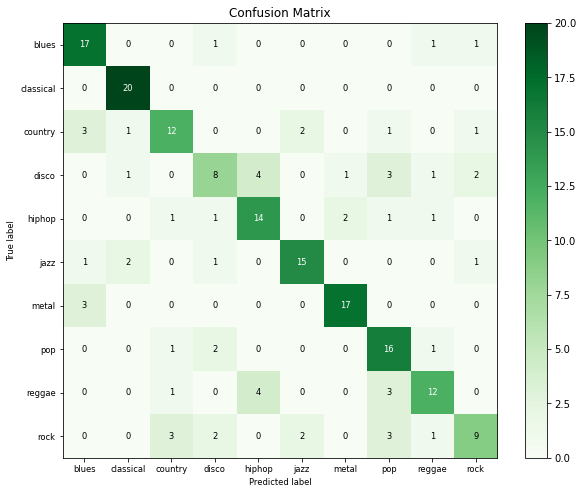

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.71      0.85      0.77        20
   classical       0.83      1.00      0.91        20
     country       0.67      0.60      0.63        20
       disco       0.53      0.40      0.46        20
      hiphop       0.64      0.70      0.67        20
        jazz       0.79      0.75      0.77        20
       metal       0.85      0.85      0.85        20
         pop       0.59      0.80      0.68        20
      reggae       0.71      0.60      0.65        20
        rock       0.64      0.45      0.53        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



In [72]:
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'soft', features_train, labels_train, features_test, labels_test, True)

Base training score: 0.99875
Accuracy: 0.69
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


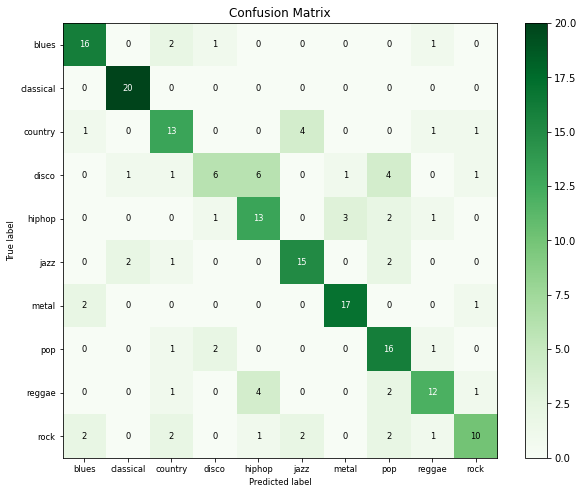

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.87      1.00      0.93        20
     country       0.62      0.65      0.63        20
       disco       0.60      0.30      0.40        20
      hiphop       0.54      0.65      0.59        20
        jazz       0.71      0.75      0.73        20
       metal       0.81      0.85      0.83        20
         pop       0.57      0.80      0.67        20
      reggae       0.71      0.60      0.65        20
        rock       0.71      0.50      0.59        20

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



In [74]:
classifier = ExtraTreesClassifier()
AdaBoost = boostModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>While we did see some improvements in performance for things like KNeighbors, removal doesn't give a much better score. In fact, we were only able to eke out a single 1% increase, flattening out the chance at a solid 70%. I have one more thing to try...</font>

<font color='blue'>I used the code below to create the new csv file in the following cells. It's not necessary to run, but I feel is important to mention.</font>
```py
header = 'chroma_stft chroma_cqt chroma_cens rms spectral_centroid spectral_bandwidth spectral_contrast spectral_flatness rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('music_data_chroma.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Music Genres Dataset/genres/{g}'):
        songname = f'./Music Genres Dataset/genres/{g}/{filename}'
        y, sr = librosa.load(songname, sr=None, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_flatness = librosa.feature.spectral_flatness(y=y)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(chroma_stft)} {np.mean(chroma_cqt)} {np.mean(chroma_cens)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_contrast)} {np.mean(spec_flatness)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('music_data_chroma.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())
```

In [37]:
chromaMusicData = pnd.read_csv("music_data_chroma.csv", header=0)

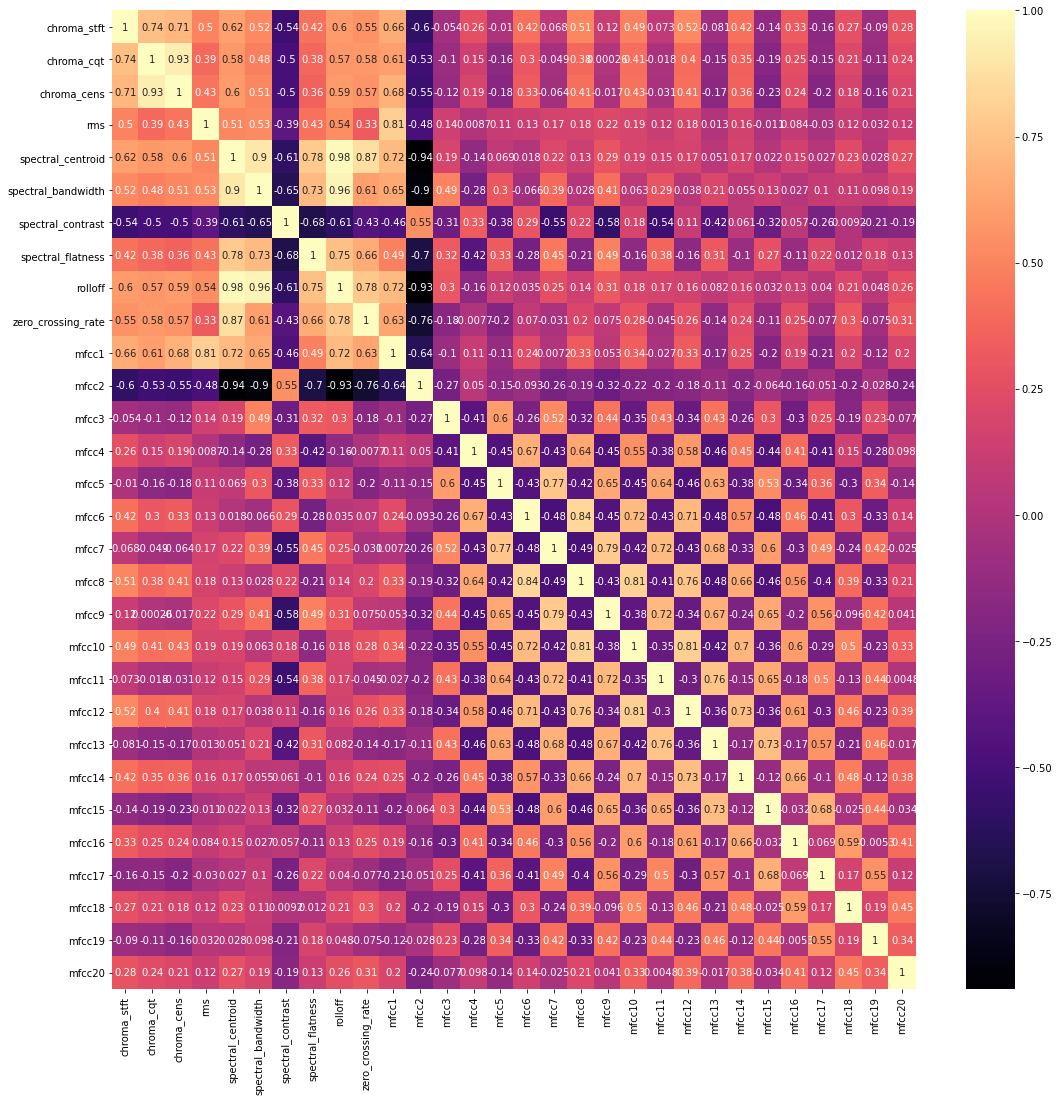

In [6]:
plt.figure(figsize=(18,18))
p=sns.heatmap(chromaMusicData.corr(), annot=True,cmap ='magma')

<font color='red'>There's three methods of mapping a chromagram, and before I had only used one. This time, I'm going to implement the other two to see if there's better results. There's some decent correlation values, so hopefully it'll help.</font>

In [38]:
chromaMusicData = chromaMusicData.drop(columns=['mfcc20', 'mfcc19', 'spectral_contrast', 'spectral_flatness'], axis=1)

X = standard_scaler.fit_transform(chromaMusicData.drop(columns=['label'], axis=1))
y = label_encoder.fit_transform(chromaMusicData['label'])

In [39]:
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

Random Forests:
Base training score: 0.79125
Base testing score: 0.56500
Mean Absolute Error (MAE): 1.52
Accuracy: 0.565
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


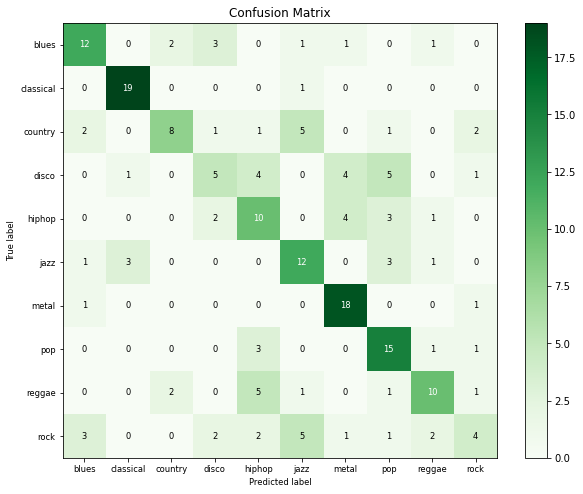

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.63      0.60      0.62        20
   classical       0.83      0.95      0.88        20
     country       0.67      0.40      0.50        20
       disco       0.38      0.25      0.30        20
      hiphop       0.40      0.50      0.44        20
        jazz       0.48      0.60      0.53        20
       metal       0.64      0.90      0.75        20
         pop       0.52      0.75      0.61        20
      reggae       0.62      0.50      0.56        20
        rock       0.40      0.20      0.27        20

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.56      0.56      0.55       200

------------------------------------------------------------------------------------------
Extra Trees:
Base training score: 0.99875
Base testing score: 0.74000
Mean Absolute Error (MAE): 0.87
Accu

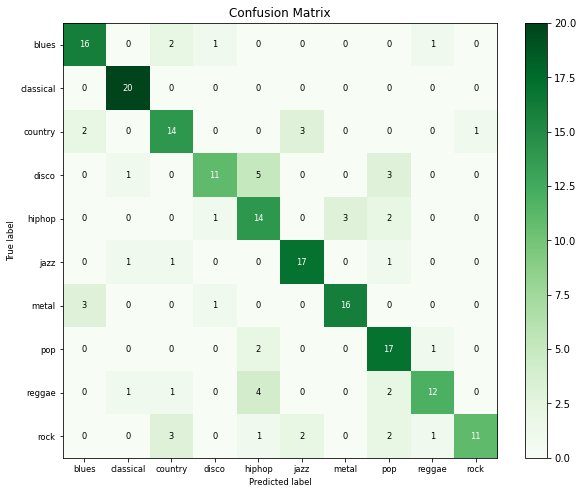

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.87      1.00      0.93        20
     country       0.67      0.70      0.68        20
       disco       0.79      0.55      0.65        20
      hiphop       0.54      0.70      0.61        20
        jazz       0.77      0.85      0.81        20
       metal       0.84      0.80      0.82        20
         pop       0.63      0.85      0.72        20
      reggae       0.80      0.60      0.69        20
        rock       0.92      0.55      0.69        20

    accuracy                           0.74       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.74      0.74       200

------------------------------------------------------------------------------------------
K Nearest Neighbors:
Base training score: 0.76500
Base testing score: 0.64000
Mean Absolute Error (MAE): 1

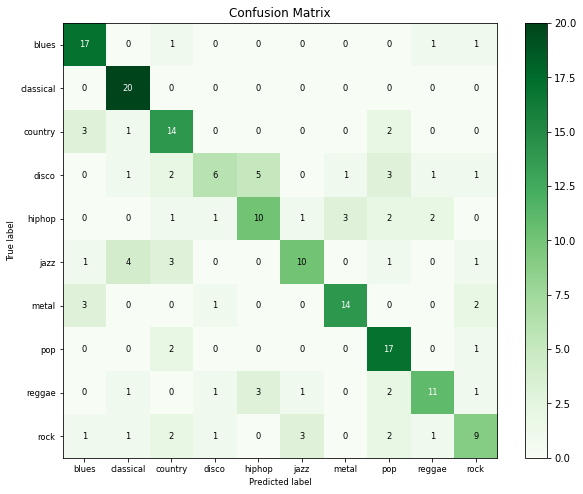

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.68      0.85      0.76        20
   classical       0.71      1.00      0.83        20
     country       0.56      0.70      0.62        20
       disco       0.60      0.30      0.40        20
      hiphop       0.56      0.50      0.53        20
        jazz       0.67      0.50      0.57        20
       metal       0.78      0.70      0.74        20
         pop       0.59      0.85      0.69        20
      reggae       0.69      0.55      0.61        20
        rock       0.56      0.45      0.50        20

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.64      0.64      0.63       200

------------------------------------------------------------------------------------------
SVC with Linear kernel:
Base training score: 0.81250
Base testing score: 0.68500
Mean Absolute Error (MAE)

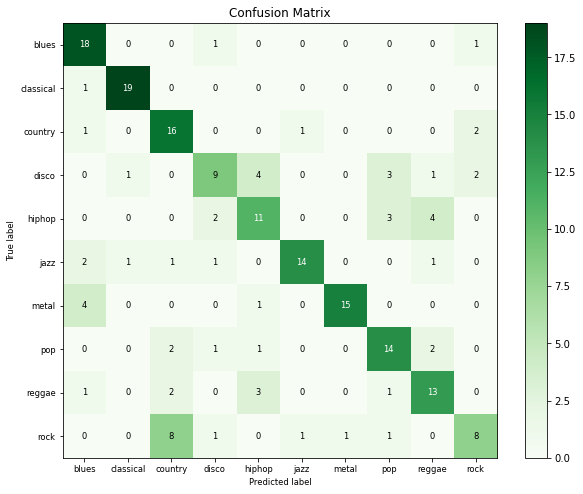

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.67      0.90      0.77        20
   classical       0.90      0.95      0.93        20
     country       0.55      0.80      0.65        20
       disco       0.60      0.45      0.51        20
      hiphop       0.55      0.55      0.55        20
        jazz       0.88      0.70      0.78        20
       metal       0.94      0.75      0.83        20
         pop       0.64      0.70      0.67        20
      reggae       0.62      0.65      0.63        20
        rock       0.62      0.40      0.48        20

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.68       200
weighted avg       0.70      0.69      0.68       200

------------------------------------------------------------------------------------------
Voting ensemble with hard voting:
Base training score: 0.9025
Base validation score: 0.73
Accuracy: 0.73
D

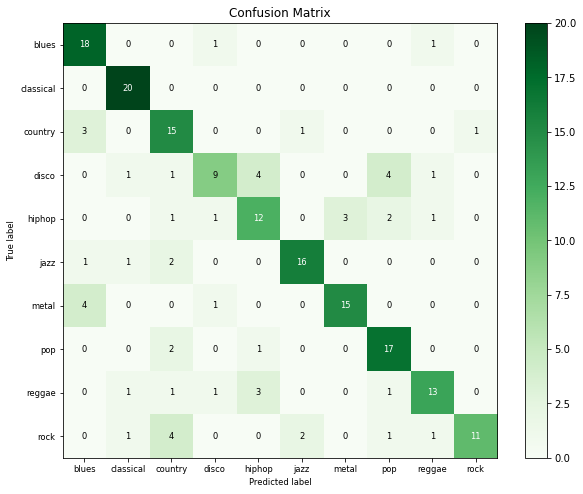

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.69      0.90      0.78        20
   classical       0.83      1.00      0.91        20
     country       0.58      0.75      0.65        20
       disco       0.69      0.45      0.55        20
      hiphop       0.60      0.60      0.60        20
        jazz       0.84      0.80      0.82        20
       metal       0.83      0.75      0.79        20
         pop       0.68      0.85      0.76        20
      reggae       0.76      0.65      0.70        20
        rock       0.92      0.55      0.69        20

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.72       200
weighted avg       0.74      0.73      0.72       200

------------------------------------------------------------------------------------------
Voting ensemble with soft voting:
Base training score: 0.99875
Base validation score: 0.71
Accuracy: 0.71


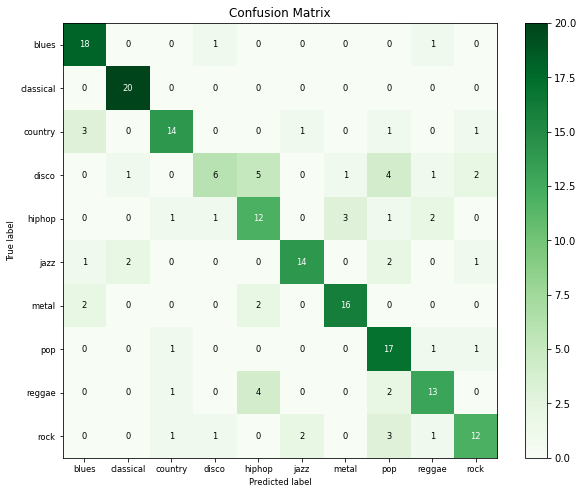

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.75      0.90      0.82        20
   classical       0.87      1.00      0.93        20
     country       0.78      0.70      0.74        20
       disco       0.67      0.30      0.41        20
      hiphop       0.52      0.60      0.56        20
        jazz       0.82      0.70      0.76        20
       metal       0.80      0.80      0.80        20
         pop       0.57      0.85      0.68        20
      reggae       0.68      0.65      0.67        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.70       200
weighted avg       0.72      0.71      0.70       200

------------------------------------------------------------------------------------------
Ada Boosting with Extra Trees:
Base training score: 0.99875
Accuracy: 0.745
Decoded genres after applying 

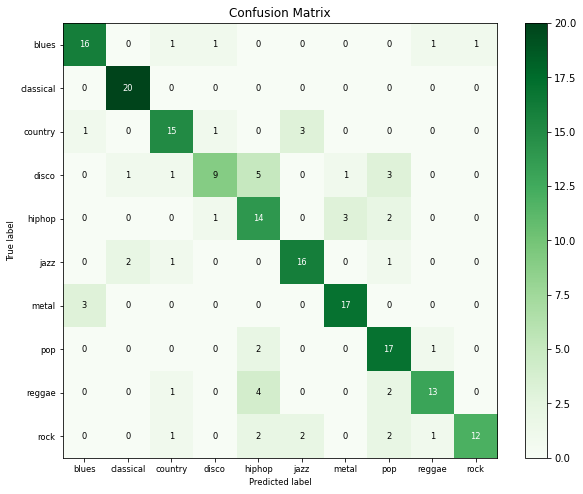

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.80      0.80      0.80        20
   classical       0.87      1.00      0.93        20
     country       0.75      0.75      0.75        20
       disco       0.75      0.45      0.56        20
      hiphop       0.52      0.70      0.60        20
        jazz       0.76      0.80      0.78        20
       metal       0.81      0.85      0.83        20
         pop       0.63      0.85      0.72        20
      reggae       0.81      0.65      0.72        20
        rock       0.92      0.60      0.73        20

    accuracy                           0.74       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.74      0.74       200



In [40]:
print('Random Forests:')
RFModel = rfModelRun(features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Extra Trees:')
ETClass = xtModelRun(features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('K Nearest Neighbors:')
KNModel = knModelRun(features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('SVC with Linear kernel:')
SVCModel = svcModelRun(features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Voting ensemble with hard voting:')
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'hard', features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Voting ensemble with soft voting:')
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'soft', features_train, labels_train, features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Ada Boosting with Extra Trees:')
classifier = ExtraTreesClassifier()
AdaBoost = boostModelRun(classifier, features_train, labels_train, features_test, labels_test, True)

<font color='red'>It looks like the most we'll be able to get out of this is around 74%, which I think is quite respectable. Overall, I'm pretty satisfied with the results, but I do wish I could have at least gotten to 80%.</font>

<font color='red'>However, with the best results we've obtained yet, lets see if we can apply some dimensionality reduction to see if we can squeeze just a little bit more out.</font>

In [60]:
chromaMusicData = pnd.read_csv("music_data_chroma.csv", header=0)

In [61]:
X = standard_scaler.fit_transform(chromaMusicData.drop(columns=['label'], axis=1))
y = label_encoder.fit_transform(chromaMusicData['label'])

In [62]:
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [67]:
from sklearn.decomposition import PCA

pca = PCA(0.97)

pca_features_train = pca.fit_transform(features_train)
pca_labels_train = pca.transform(labels_train.reshape(-1, 1))
pca_features_test = pca.transform(features_test)
pca_labels_test = pca.transform(labels_test.reshape(-1, 1))

pca.n_components_

20

<font color='red'>Okay, the number of components has definitely been reduced. Let's give it another try...</font>

Random Forests:
Base training score: 0.84000
Base testing score: 0.60500
Mean Absolute Error (MAE): 1.405
Accuracy: 0.605
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


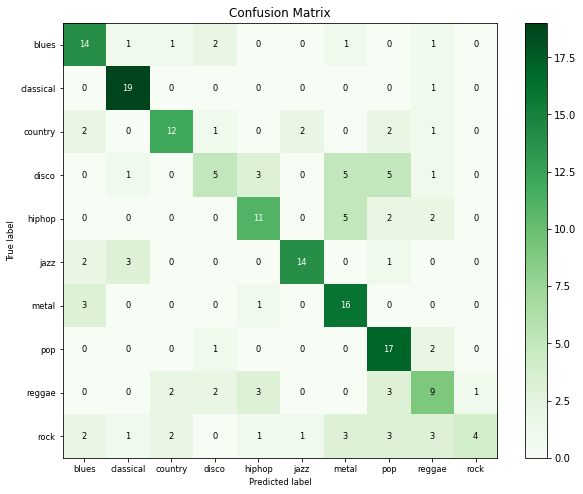

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.61      0.70      0.65        20
   classical       0.76      0.95      0.84        20
     country       0.71      0.60      0.65        20
       disco       0.45      0.25      0.32        20
      hiphop       0.58      0.55      0.56        20
        jazz       0.82      0.70      0.76        20
       metal       0.53      0.80      0.64        20
         pop       0.52      0.85      0.64        20
      reggae       0.45      0.45      0.45        20
        rock       0.80      0.20      0.32        20

    accuracy                           0.60       200
   macro avg       0.62      0.61      0.58       200
weighted avg       0.62      0.60      0.58       200

------------------------------------------------------------------------------------------
Extra Trees:
Base training score: 0.99875
Base testing score: 0.69500
Mean Absolute Error (MAE): 1.08
Accu

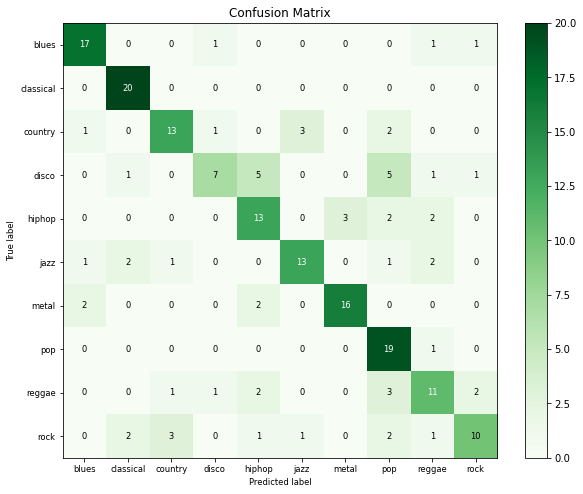

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.81      0.85      0.83        20
   classical       0.80      1.00      0.89        20
     country       0.72      0.65      0.68        20
       disco       0.70      0.35      0.47        20
      hiphop       0.57      0.65      0.60        20
        jazz       0.76      0.65      0.70        20
       metal       0.84      0.80      0.82        20
         pop       0.56      0.95      0.70        20
      reggae       0.58      0.55      0.56        20
        rock       0.71      0.50      0.59        20

    accuracy                           0.69       200
   macro avg       0.71      0.70      0.69       200
weighted avg       0.71      0.69      0.69       200

------------------------------------------------------------------------------------------
K Nearest Neighbors:
Base training score: 0.78375
Base testing score: 0.63500
Mean Absolute Error (MAE): 1

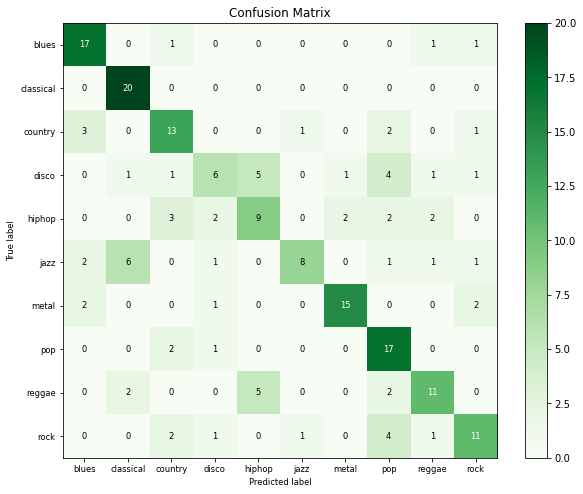

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.71      0.85      0.77        20
   classical       0.69      1.00      0.82        20
     country       0.59      0.65      0.62        20
       disco       0.50      0.30      0.37        20
      hiphop       0.47      0.45      0.46        20
        jazz       0.80      0.40      0.53        20
       metal       0.83      0.75      0.79        20
         pop       0.53      0.85      0.65        20
      reggae       0.65      0.55      0.59        20
        rock       0.65      0.55      0.59        20

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.62       200
weighted avg       0.64      0.64      0.62       200

------------------------------------------------------------------------------------------
SVC with Linear kernel:
Base training score: 0.78375
Base testing score: 0.65500
Mean Absolute Error (MAE)

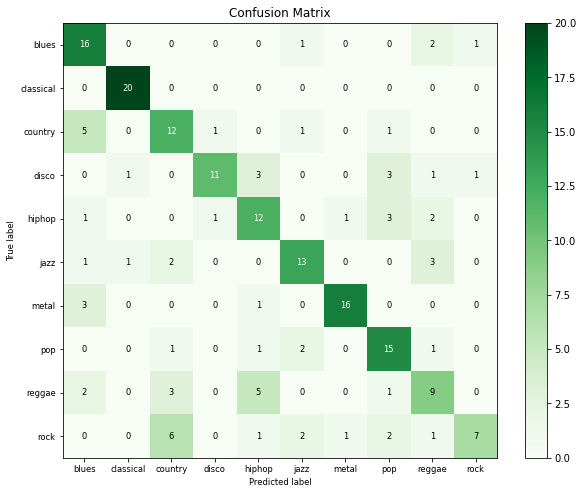

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.57      0.80      0.67        20
   classical       0.91      1.00      0.95        20
     country       0.50      0.60      0.55        20
       disco       0.85      0.55      0.67        20
      hiphop       0.52      0.60      0.56        20
        jazz       0.68      0.65      0.67        20
       metal       0.89      0.80      0.84        20
         pop       0.60      0.75      0.67        20
      reggae       0.47      0.45      0.46        20
        rock       0.78      0.35      0.48        20

    accuracy                           0.66       200
   macro avg       0.68      0.66      0.65       200
weighted avg       0.68      0.66      0.65       200

------------------------------------------------------------------------------------------
Voting ensemble with hard voting:
Base training score: 0.905
Base validation score: 0.695
Accuracy: 0.695


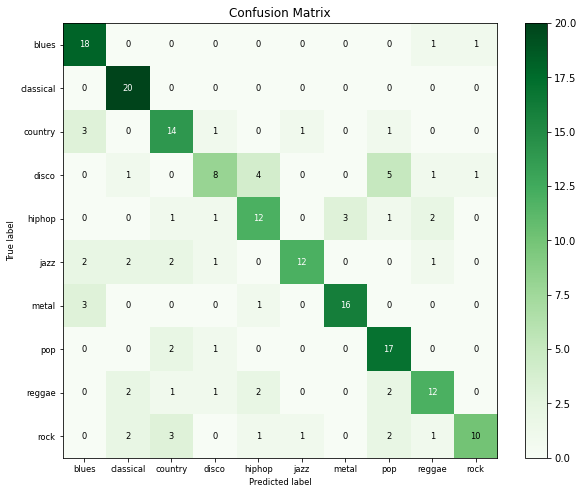

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.69      0.90      0.78        20
   classical       0.74      1.00      0.85        20
     country       0.61      0.70      0.65        20
       disco       0.62      0.40      0.48        20
      hiphop       0.60      0.60      0.60        20
        jazz       0.86      0.60      0.71        20
       metal       0.84      0.80      0.82        20
         pop       0.61      0.85      0.71        20
      reggae       0.67      0.60      0.63        20
        rock       0.83      0.50      0.62        20

    accuracy                           0.69       200
   macro avg       0.71      0.69      0.69       200
weighted avg       0.71      0.69      0.69       200

------------------------------------------------------------------------------------------
Voting ensemble with soft voting:
Base training score: 0.99875
Base validation score: 0.72
Accuracy: 0.72


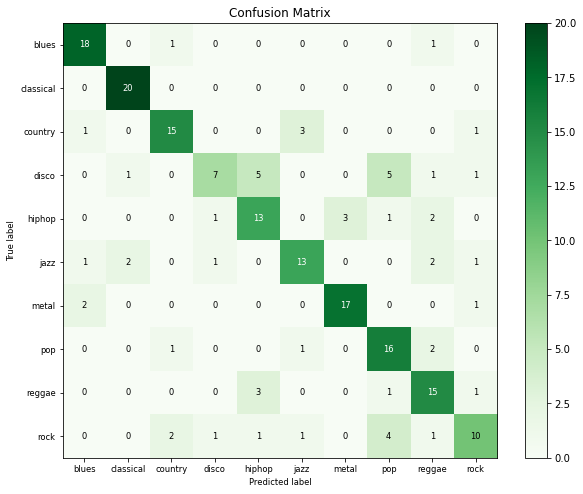

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.82      0.90      0.86        20
   classical       0.87      1.00      0.93        20
     country       0.79      0.75      0.77        20
       disco       0.70      0.35      0.47        20
      hiphop       0.59      0.65      0.62        20
        jazz       0.72      0.65      0.68        20
       metal       0.85      0.85      0.85        20
         pop       0.59      0.80      0.68        20
      reggae       0.62      0.75      0.68        20
        rock       0.67      0.50      0.57        20

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.72      0.71       200

------------------------------------------------------------------------------------------
Ada Boosting with Extra Trees:
Base training score: 0.99875
Accuracy: 0.71
Decoded genres after applying i

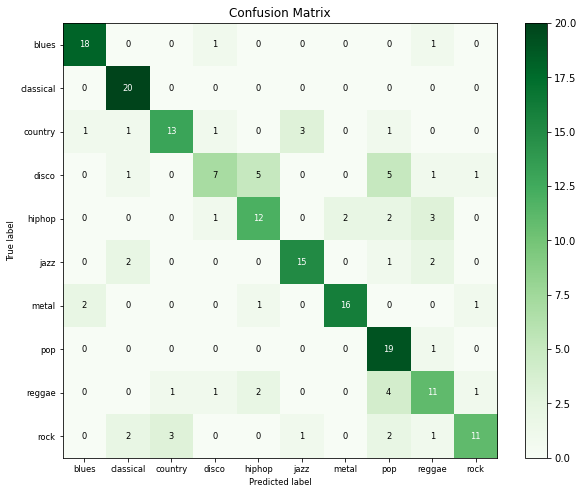

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.86      0.90      0.88        20
   classical       0.77      1.00      0.87        20
     country       0.76      0.65      0.70        20
       disco       0.64      0.35      0.45        20
      hiphop       0.60      0.60      0.60        20
        jazz       0.79      0.75      0.77        20
       metal       0.89      0.80      0.84        20
         pop       0.56      0.95      0.70        20
      reggae       0.55      0.55      0.55        20
        rock       0.79      0.55      0.65        20

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.70       200
weighted avg       0.72      0.71      0.70       200

------------------------------------------------------------------------------------------
Ada Boosting with SVC
Base training score: 0.55375
Accuracy: 0.55
Decoded genres after applying inverse of

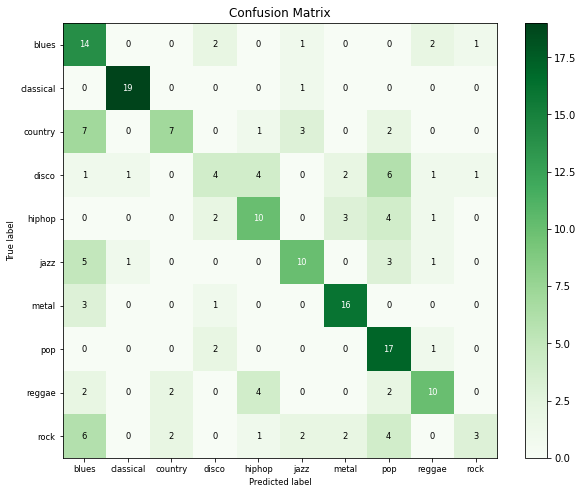

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.37      0.70      0.48        20
   classical       0.90      0.95      0.93        20
     country       0.64      0.35      0.45        20
       disco       0.36      0.20      0.26        20
      hiphop       0.50      0.50      0.50        20
        jazz       0.59      0.50      0.54        20
       metal       0.70      0.80      0.74        20
         pop       0.45      0.85      0.59        20
      reggae       0.62      0.50      0.56        20
        rock       0.60      0.15      0.24        20

    accuracy                           0.55       200
   macro avg       0.57      0.55      0.53       200
weighted avg       0.57      0.55      0.53       200



In [68]:
print('Random Forests:')
RFModel = rfModelRun(pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Extra Trees:')
ETClass = xtModelRun(pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('K Nearest Neighbors:')
KNModel = knModelRun(pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('SVC with Linear kernel:')
SVCModel = svcModelRun(pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Voting ensemble with hard voting:')
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'hard', pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Voting ensemble with soft voting:')
estimators = [('et', ETClass), ('kn', KNModel), ('svc', SVCModel)]
VoteModel = voteModelRun(estimators, 'soft', pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Ada Boosting with Extra Trees:')
classifier = ExtraTreesClassifier()
AdaBoost = boostModelRun(classifier, pca_features_train, labels_train, pca_features_test, labels_test, True)
print('------------------------------------------------------------------------------------------')

print('Ada Boosting with SVC')
classifier = SVC(kernel='linear', probability=True)
AdaBoost = boostModelRun(classifier, pca_features_train, labels_train, pca_features_test, labels_test, True)

<font color='red'>Dang, still not a significant performance increase. In fact, it's a performance hit in some cases. I gave it everything I could.</font>

## *Lessons Learned*

This was a fascinating look at how helpful it is knowing about the domain your data is in. Being able to understand what chromagrams, spectral centroids, and the zero crossing rate are and how they correlate to the music genre can help with manipulating and improving the results of the model being used. This project has also highlighted some of the limitations of classification, and how important lots of data can be for these models. If I had the time to bolster it myself, I would, but that's a lot of music to aggregate...